In [1]:
import matplotlib.pyplot as plt
from pprint import pprint
import joblib
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from train import save_model, train, get_classifier, evaluate
from model import NNModel
from logit_dataset import LogitDataset

## train

In [87]:
# 527-dim logits
clf = get_classifier(527)

In [85]:
from distillation.data.linked_json import LinkedJsonDatabase

def prepare_datasets(val_ds_name, db_path, embedding_db_path):
    """
    [
    example_id: {'example_id':example_id, 'weak_targets': one-hot, 'logits': logits}
    ]
    """
    emb_db = LinkedJsonDatabase(embedding_db_path)
    db = LinkedJsonDatabase(db_path)
    
    train_ds_name = "train_50"
    train_logits = np.array([a['logits'] for a in emb_db.get_dataset(train_ds_name).values()])
    validate_logits = np.array([a['logits'] for a in emb_db.get_dataset(val_ds_name).values()])
    return train_logits, validate_logits

In [86]:
from nt_paths import db_root, json_root
target_embedding_db_path = db_root + "/logits/tau2022_repeat_ensemble_logits/database.json"
target_db_path = json_root + "/tau2022.json"
train_logits, validate_logits = prepare_datasets(val_ds_name="test",
                                            db_path=target_db_path,
                                            embedding_db_path=target_embedding_db_path)
db = LogitDataset(train_logits=train_logits, validate_logits=validate_logits)

/net/home/werning/projects/distillation/distillation/data/linked_json.py:35: UserWarning: No external files referenced, is this a LinkedJsonDatabase file?
  warnings.warn("No external files referenced, is this a LinkedJsonDatabase file?")


In [76]:
db.num_train_samples

155555

In [ ]:
## training

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.38it/s]


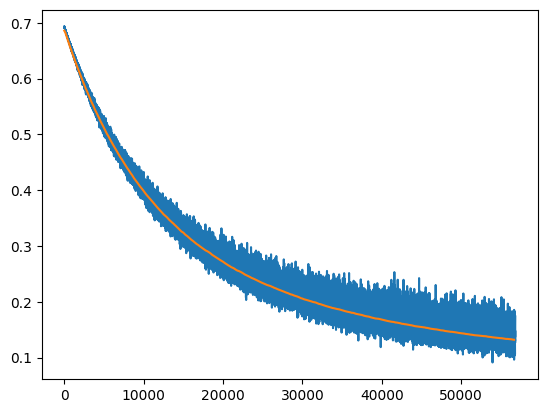

In [88]:
batch_size = 600
clf, train_losses, validate_losses = train(clf,
                                           db,
                                           mixup=0,
                                            batch_size=batch_size,
                                            epochs=400,
                                            lr=1e-4)
epoch_len = db.num_train_samples // batch_size
train_x = range(len(train_losses))
validate_x = epoch_len*np.arange(len(train_losses)//epoch_len)
plt.plot(train_x, train_losses, label='train loss')
plt.plot(validate_x, validate_losses, label='validate_loss')

In [11]:
## least squares solution

In [ ]:
# db.train_positive_samples
# # {logits, targets}
# db.train_negative_samples
# pos_logits = db.train_positive_samples['logits']
# neg_logits = db.train_negative_samples['logits']
# logit_arr = np.concatenate((pos_logits, neg_logits), axis=0)
# data_matrix = np.concatenate((np.ones((len(logit_arr), 1)), logit_arr), axis=1)
# targets = np.zeros((len(logit_arr),2))
# targets[:len(pos_logits),0] = 1
# targets[len(pos_logits):,1] = 1
# # assert targets.shape = Nx2
# weights = np.linalg.pinv(data_matrix)@targets
# weight = weights[1:]
# bias = weights[:1]


In [ ]:
# pred = (logit_arr @ weight+ bias)

In [ ]:
# plt.hist(pred)

In [ ]:
# ((pred[:,0]>pred[:,1]) == targets[:,0]).sum()/len(targets)

## eval

In [34]:
# clf = joblib.load("/net/vol/werning/old_storage/relabel_model/domain_classifier3/model.joblib").clf
# clf = joblib.load("/net/vol/werning/storage/relabel_model_tau2022/domain_classifier_no_mixup/model_5.joblib").clf

In [89]:
clf = clf.cuda()
threshold=0.1
model = NNModel(clf, threshold)

In [90]:
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(f"threshold {threshold}")
    model = NNModel(clf, threshold)
    res = evaluate(model, db)
    # pprint(res['confusion'])
    # pprint(res['class_weighted_confusion'])
    print(f"precision: {100*res['weighted_precision']:0.1f}%")
    print(f"recall: {100*res['weighted_recall']:0.1f}%")
    joblib.dump(model, f"/net/vol/werning/storage/relabel_model_tau2022/domain_classifier_no_mixup_repeated/model_split_50_{int(threshold*10)}.joblib")

threshold 0.1
precision: 82.4%
recall: 100.0%
threshold 0.2
precision: 87.2%
recall: 100.0%
threshold 0.3
precision: 90.1%
recall: 100.0%
threshold 0.4
precision: 92.2%
recall: 99.9%
threshold 0.5
precision: 93.9%
recall: 99.8%
threshold 0.6
precision: 95.6%
recall: 99.4%
threshold 0.7
precision: 96.7%
recall: 97.6%
threshold 0.8
precision: 97.5%
recall: 90.2%
threshold 0.9
precision: 96.9%
recall: 49.7%


# trained:
           true  false
positive  28388    289
negative   3645   1292
              true     false
positive  0.956469  0.073462
negative  0.926538  0.043531
precision: 92.9%
recall: 95.6%

In [28]:
joblib.dump(model, f"/net/vol/werning/storage/relabel_model_tau2022/domain_classifier_no_mixup_repeated/model_{int(threshold*10)}.joblib")

['/net/vol/werning/storage/relabel_model_tau2022/domain_classifier_no_mixup/model_1.joblib']

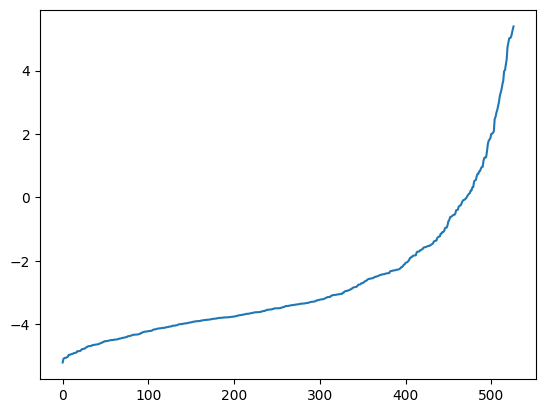

In [91]:
plt.plot(sorted(np.asarray(clf[1].weight.detach().cpu().numpy())[0]))

In [ ]:
# most relevant positive and negative classes (assume: threshold for all classes is similar, which is not the case)

In [81]:
import paderbox as pb
audioset_classes = pb.io.load("/net/home/werning/projects/target_distillation/target_distillation/events/audioset_events.json")
vals = clf[1].weight.detach().cpu().numpy()[0]
print("\n".join(map(str, reversed(sorted(zip(vals, audioset_classes))[-10:]))))
print("\n".join(map(str, reversed(sorted(zip(vals, audioset_classes))[:10]))))

(9.463436, 'Buzz')
(9.269957, 'Heavy engine (low frequency)')
(8.253997, 'Techno')
(8.054645, 'Field recording')
(7.7425394, 'Flap')
(7.4426823, 'Rumble')
(7.0580673, 'White noise')
(6.7212744, 'Rustle')
(5.487844, 'Hubbub, speech noise, speech babble')
(5.4377837, 'Shuffle')
(-8.663184, 'Classical music')
(-8.752643, 'Jingle (music)')
(-8.761996, 'Smash, crash')
(-8.76493, 'Song')
(-8.774451, 'Singing')
(-8.821637, 'Christian music')
(-9.00974, 'Tools')
(-9.06758, 'Wood')
(-9.099043, 'Wedding music')
(-9.108679, 'Door')
